# VAE Utilized As a Static Novelty Detection

In [1]:
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import axis, colorbar, imshow, show, figure, subplot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
%matplotlib inline

import glob
import json
import csv

import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization, ReLU, LeakyReLU
from keras.models import Model
from keras.losses import binary_crossentropy, mse
from keras import backend as K                         #contains calls for tensor manipulations

Using TensorFlow backend.


In [2]:
print (tf.__version__)
print (keras.__version__)

2.1.0
2.3.1


In [3]:
tf.random.set_seed(42)
np.random.seed(42)

# Define paths

In [4]:
from utils_vae_eval_paths import *

# What latent dimension and filter size are we using?:
latent_dim = 8

PATH = f'{kitkatdir}/saved_models'

# Get work direction for saving files:
TRAINED_MODELS = f'{PATH}/latent{latent_dim}'

In [5]:
save_plots = False

if save_plots == True:
    print ('Save figures in subfolder:', FIGURES_FOLDER)

In [6]:
save_measurements   = False
append_measurements = False
    
if append_measurements == True:
    print ('Append measurements in subfolder:', MEASUREMENTS_FOLDER)

if save_measurements == True:
    print ('Save measurements in subfolder:', MEASUREMENTS_FOLDER)

Append measurements in subfolder: /home/jovyan/work/Speciale/FoodSorting/VariationalAutoencoder/KitKatCunkyNew/evaluations/SavedMeasurements


# Load pre-traned model weights and other hyperparameters



### Load Images

In [7]:
print("[INFO] loading trained models and images...")

# load history from the trained model:
history = np.load(f'{TRAINED_MODELS}/HISTORY.npy', allow_pickle='TRUE').item()

# load training and testing images:
trainX   = np.load(f'{TRAINED_MODELS}/trainX.npy', allow_pickle='TRUE')       # training samples
valX     = np.load(f'{TRAINED_MODELS}/valX.npy', allow_pickle='TRUE')         # validation samples
testAllX = np.load(f'{TRAINED_MODELS}/testAllX.npy', allow_pickle='TRUE')     # all test samples
testAllY = np.load(f'{TRAINED_MODELS}/testAllY.npy', allow_pickle='TRUE')     # all test labels

print("          done")

[INFO] loading trained models and images...
          done


### Load Hyperparameters

In [8]:
txtfile = open(f'{TRAINED_MODELS}/notes.txt')

for line in txtfile:
    print(line)
    
# load some hyperparameters and data configurations automatic:
hyper_parameters = []
with open((f'{TRAINED_MODELS}/notes.txt'), 'r') as f:
    for l in f: 
        strnumbers = l.split(':')
        hyper_parameters.append(json.loads(strnumbers[1]))
        
no_epochs = hyper_parameters[0]
latent_dim = hyper_parameters[2]
img_width = hyper_parameters[4]
img_height = hyper_parameters[5]
num_channels = hyper_parameters[6]

Epochs: 2000 

Batch size: 256 

Latent dimension: 8 

Filter sizes: 32 

img_width: 128 

img_height: 128 

num_channels: 1


### Load VAE Architecture and its weights at final epoch

In [9]:
# improt architecture of encoder, decoder and VAE model:
from J8_VAE_model import *

In [10]:
# summarize architecture of encoder part:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   9248        leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [11]:
# summarize architecture of decoder part:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4608      
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 32)          9248      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 32)        9248      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 16, 16, 32)        0   

In [12]:
# summarize architecture of VAE model:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 128, 128, 1)       0         
_________________________________________________________________
encoder (Model)              [(None, 8), (None, 8), (N 143128    
_________________________________________________________________
decoder (Model)              (None, 128, 128, 1)       51137     
Total params: 194,265
Trainable params: 194,265
Non-trainable params: 0
_________________________________________________________________


In [13]:
""" load the final weight for the Encoder part """
encoder.load_weights(f'{TRAINED_MODELS}/ENCODER_WEIGHTS.h5')

""" load the final weight for the Encoder part """
decoder.load_weights(f'{TRAINED_MODELS}/DECODER_WEIGHTS.h5')

""" load the final weight for the VAE """
# Create a new model instance:
vae = create_model()
# Load the previously saved weights:
vae.load_weights(f'{TRAINED_MODELS}/VAE_WEIGHTS.h5', by_name=True)

/opt/conda/envs/python3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


# Evaluate model

## Loss History

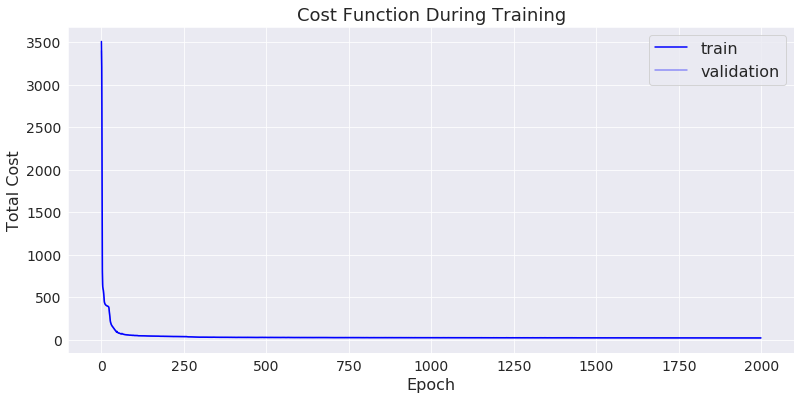

In [14]:
plt.figure(figsize=(13, 6))

# summarize history for loss:
plt.plot(history['loss'], color='blue', label='train')
plt.plot(history['val_loss'], color='blue', alpha=0.4, label='validation')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Total Cost', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Cost Function During Training', fontsize=18)

#plt.xlim(10,no_epochs)
#plt.ylim(0,1000)
#np.arange(0, no_epochs, step=10)
plt.legend(loc='upper right', fontsize=16)
plt.show()

## Inference

Predictions and metrices where the VAE is utilized as a static novelty detection.

__Split Testing Data Into Their Corresponding Correctly Labeled Classes__

https://stackoverflow.com/questions/44883905/randomly-remove-x-elements-from-a-list

In [15]:
from utils_VAE_AE import subsplit, delete_rand_items, KITKAT_get_counts

# Class 0:
testNormalX, testNormalY = subsplit(testAllX , testAllY, class_label=0)

# Class 1:
testAnomalyX, testAnomalyY = subsplit(testAllX , testAllY, class_label=1)

In [16]:
n_normal_original, n_anomaly_original = len(testNormalY), len(testAnomalyY)

print ("number of normal samples: ", n_normal_original)
print ("number of anomaly samples:", n_anomaly_original)

number of normal samples:  400
number of anomaly samples: 600


In [17]:
""" set anomaly ratio """
anomaly_rate = 50

""" randomly remove n normal and anomalous samples """
n_normal_remove, n_anomaly_remove = KITKAT_get_counts(n_normal_original, n_anomaly_original, anomaly_rate=anomaly_rate)

testNormalX, testNormalY = delete_rand_items(testNormalX, n_normal_remove), delete_rand_items(testNormalY, n_normal_remove)
testAnomalyX, testAnomalyY = delete_rand_items(testAnomalyX, n_anomaly_remove), delete_rand_items(testAnomalyY, n_anomaly_remove)
testAllX = np.concatenate([testNormalX, testAnomalyX])

print ("new number of normal samples: ", len(testNormalY))
print ("new number of anomaly samples:", len(testAnomalyY))

new number of normal samples:  340
new number of anomaly samples: 340


__Predictions__

In [18]:
"""make predictions of unseen testing data"""
predNormal   = vae.predict(testNormalX)
predAnomaly  = vae.predict(testAnomalyX)

### Compare Reconstructions to Originals

Samples of the VAE's outputs for both good and bad images

In [19]:
from utils_VAE_AE import plot_reconstructions

#### Class 0: Normal Samples

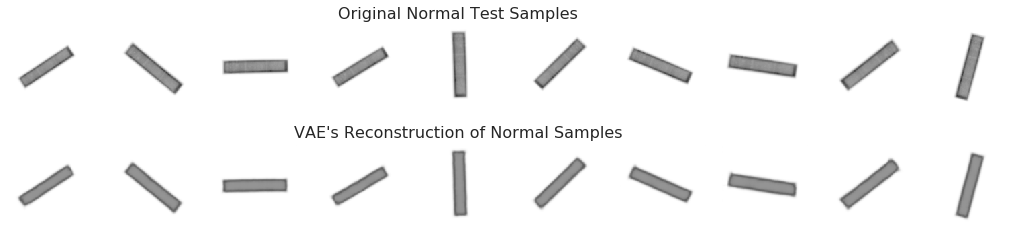

In [20]:
plot_reconstructions(testNormalX, predNormal, n=10, img_width=img_width, img_height=img_height, 
                         title1='Original Normal Test Samples', title2="VAE's Reconstruction of Normal Samples")

#### Class 1: Anomaly Samples

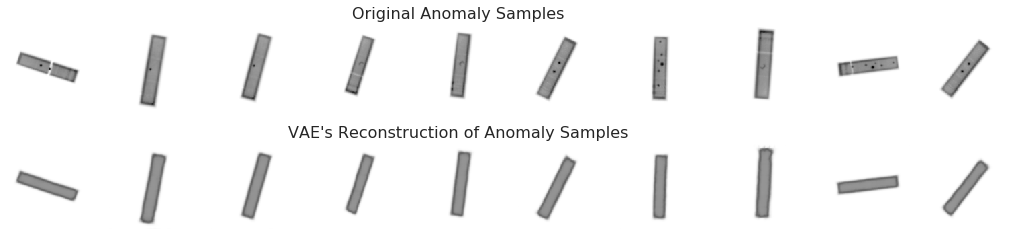

In [21]:
plot_reconstructions(testAnomalyX, predAnomaly, n=10, img_width=img_width, img_height=img_height, 
                         title1='Original Anomaly Samples', title2="VAE's Reconstruction of Anomaly Samples")

### Static Novelty Detection

In [22]:
import scipy

from utils_VAE_AE import rec_statistics, ZNCC_measure

#### Reconstruction Error: Distributions

In [23]:
rec0 = 1 - ZNCC_measure(testNormalX, predNormal) 
rec0_mean, rec0_err, rec0_RMS = rec_statistics(rec0)
print ("Histogram Statistics over Normal Samples (Class 0):")
print(f"   Mean of Reconstruction Error:  ({rec0_mean:.5f} +/- {rec0_err:.5f})     (RMS = {rec0_RMS:.5f})")
print (" ")

rec1 = 1 - ZNCC_measure(testAnomalyX, predAnomaly)
rec1_mean, rec1_err, rec1_RMS = rec_statistics(rec1)
print ("Histogram Statistics over Anomaly Samples (Class 1):")
print(f"   Mean of Reconstruction Error:  ({rec1_mean:.5f} +/- {rec1_err:.5f})     (RMS = {rec1_RMS:.5f})")
print (" ")

Histogram Statistics over Normal Samples (Class 0):
   Mean of Reconstruction Error:  (0.00741 +/- 0.00018)     (RMS = 0.00341)
 
Histogram Statistics over Anomaly Samples (Class 1):
   Mean of Reconstruction Error:  (0.02141 +/- 0.00022)     (RMS = 0.00404)
 


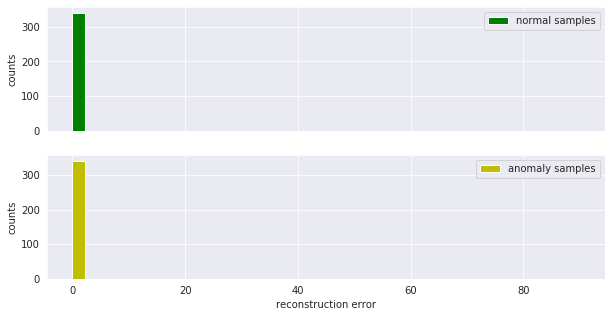

In [24]:
# histogram
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.hist(rec0, bins=40, range=(0,90), color='g', label='normal samples')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel("counts")
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(rec1, bins=40, range=(0,90), color='y', label='anomaly samples')
plt.xlabel("reconstruction error")
plt.ylabel("counts")
plt.legend()

plt.show()

#### Optimal Threshold Selection Based Upon ROC and G-mean

In [25]:
# Save reconstruction errors:
if save_measurements == True:
    np.save(f'{MEASUREMENTS_FOLDER}/J{latent_dim}_rec0.npy', rec0)
    np.save(f'{MEASUREMENTS_FOLDER}/J{latent_dim}_rec1.npy', rec1)

In [26]:
""" Compute ROC Curve using Anomaly Score"""
anomaly_score = np.concatenate([rec0, rec1], 0)
true_label = [0]*testNormalX.shape[0] + [1]*testAnomalyX.shape[0]  # Here: normal==0 and anomaly==1

  --> G-Mean=0.975, 
  --> Optimal Threshold Value is: 0.013453


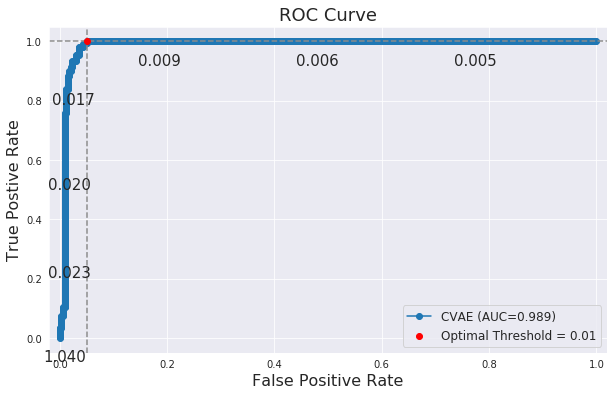

In [27]:
fpr, tpr, thresholds = roc_curve(true_label, anomaly_score, drop_intermediate=None)
auc_score = roc_auc_score(true_label, anomaly_score)

fig, ax1 = plt.subplots(1, 1, figsize = (10, 6))

# plot ROC Curves:
ax1.plot(fpr, tpr, '-o', label = 'CVAE (AUC=%2.3f)' %  auc_score)
#ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')

# plot some thresholds:
thresholds_every = 100
thresholdsLength = len(thresholds)
#colorMap=plt.get_cmap('jet', thresholdsLength)
for i in range(0, thresholdsLength, thresholds_every):
    threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
    plt.text(fpr[i] - 0.03, tpr[i] - 0.08, threshold_value_with_max_four_decimals, 
             fontdict={'size': 15}); #color=colorMap(i/thresholdsLength))

# calculate the Geometric-mean of the errors (g-mean) for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
optimal_idx = np.argmax(gmeans)                              # locate the index of the largest g-mean
print('  --> G-Mean=%.3f, \n  --> Optimal Threshold Value is: %f' % (gmeans[optimal_idx], thresholds[optimal_idx]))

# plot optimal threshold
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='r', zorder=5, 
            label='Optimal Threshold = %.2f' % (thresholds[optimal_idx]))
plt.axvline(x=fpr[optimal_idx], color='#8c8c8c', linestyle="--")
plt.axhline(y=tpr[optimal_idx], color='#8c8c8c', linestyle="--")

plt.xlabel('False Positive Rate', fontsize=16)   #FPR ($1$ - TNR)
plt.ylabel('True Postive Rate', fontsize=16)               # TPR
plt.xlim([-0.02, 1.02])
plt.ylim([-0.05, 1.05]) #plt.ylim([-0.02, 1.03])
plt.title("ROC Curve", fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

#### Threshold Evaluating

In [28]:
from utils_VAE_AE import plot_density_histograms, plot_density_histograms_ALL, compute_anomalies, plot_anomalies

In [29]:
# select optimal threshold value based upon the ROC Curve analysis above:
optimal_threshold = thresholds[optimal_idx]

##### Histograms

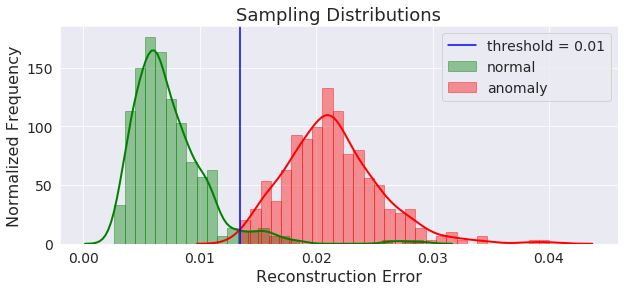

In [30]:
plot_density_histograms(rec0, rec1, optimal_threshold, bins=30)

##### Reconstruction Error Plot

In [31]:
# stack all labels:
testACombinedY = np.hstack([testNormalY, testAnomalyY])

# Static Novelty Detection:
df = compute_anomalies(rec0, rec1, testACombinedY, threshold=optimal_threshold, shuffle=True)
#display(df)

In [32]:
# count true labels:
df['y_Actual'].value_counts()

1    340
0    340
Name: y_Actual, dtype: int64

In [33]:
# count predicted labels:
df['y_Predicted'].value_counts()

1    357
0    323
Name: y_Predicted, dtype: int64

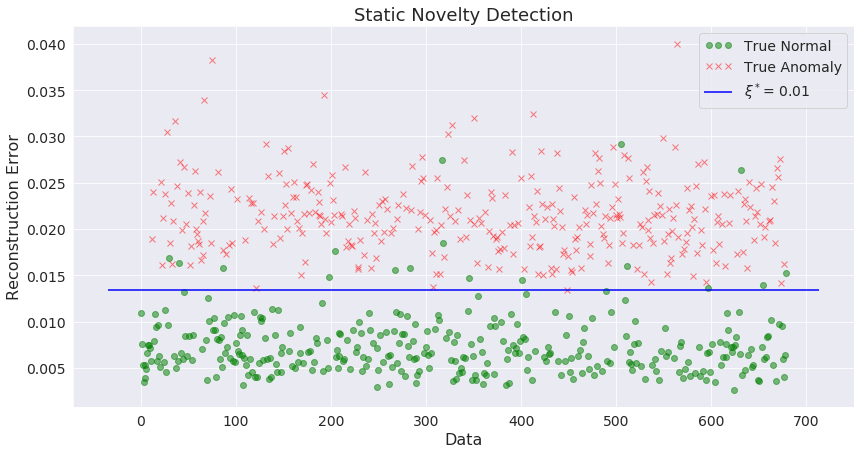

In [34]:
plot_anomalies(df, threshold=optimal_threshold)

#### Evaluating Metrices Based Upon Optimal Threshold

In [35]:
from utils_VAE_AE import plot_confusion_matrix

##### Confusion Matrix


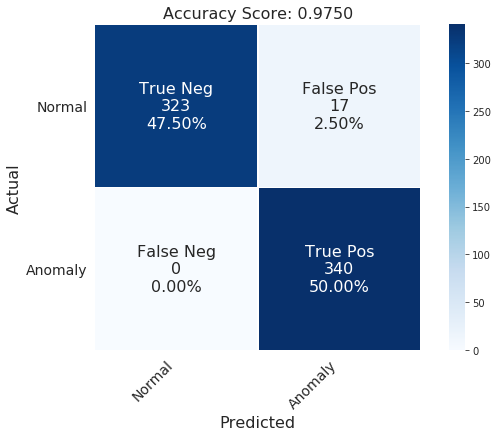

In [36]:
plot_confusion_matrix(df)

_Compute how many corerctly predicted (TP+TF) and wrongly predicted (FP+FN) out of total_

In [37]:
# Compute Confusion Matrix
conf_max = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

"""Compute Predicted Percentages of Good vs. Bad Samples"""
print('Correctly predicted (total):  {0}/{1}   -->  {2:.2f} %'
      .format(np.sum(np.diag(conf_max.to_numpy())), np.sum(conf_max.to_numpy()), 
        np.sum(np.diag(conf_max.to_numpy())) / np.sum(conf_max.to_numpy()) * 100 )
     )

print('Wrongly predicted (total):    {0}/{1}   -->  {2:.2f} %'
      .format(
        (np.sum(conf_max.to_numpy()) - np.sum(np.diag(conf_max.to_numpy()))), 
        np.sum(conf_max.to_numpy()),
        ((np.sum(conf_max.to_numpy()) - np.sum(np.diag(conf_max.to_numpy()))) 
             / np.sum(conf_max.to_numpy())) * 100
             ))

Correctly predicted (total):  663/680   -->  97.50 %
Wrongly predicted (total):    17/680   -->  2.50 %


_Compute how many normal samples have been predicted compared to predicted anomaly samples_

In [38]:
# Get a tuple of unique values & their frequency in numpy array
uniqueValues, occurCount = np.unique(df['y_Predicted'].to_numpy(), return_counts=True)

print("Unique Values: \t    " , uniqueValues)
print("Occurrence Count: ", occurCount)

Unique Values: 	     [0 1]
Occurrence Count:  [323 357]


In [39]:
print(f"Out of the total test set there are predicted to be {(occurCount[np.where(uniqueValues == 0)][0] / np.sum(conf_max.to_numpy())) * 100:.2f} % normal samples")
print(f"Out of the total test set there are predicted to be {(occurCount[np.where(uniqueValues == 1)][0] / np.sum(conf_max.to_numpy())) * 100:.2f} % anomaly samples")

Out of the total test set there are predicted to be 47.50 % normal samples
Out of the total test set there are predicted to be 52.50 % anomaly samples


##### Classification Report

Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

In [40]:
# Quantitative evaluation of the model quality on the full test set
print (classification_report(df['y_Actual'].to_numpy(), df['y_Predicted'].to_numpy(), target_names=['Normal', 'Anomaly']))

              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97       340
     Anomaly       0.95      1.00      0.98       340

    accuracy                           0.97       680
   macro avg       0.98      0.97      0.97       680
weighted avg       0.98      0.97      0.97       680



In [41]:
# get values in dictonary:
report = classification_report(df['y_Actual'].to_numpy(), df['y_Predicted'].to_numpy(), output_dict=True)

specificity     =  report['0']['recall']                # specificity aka true negative rate (TNR)
sensitivity     =  report['1']['recall']                # sensitivity, recall or true positive rate (TPR)
precision       =  report['1']['precision']             # precision (aka Positive Predictive Value, PPV) 
macro_precision =  report['macro avg']['precision'] 
macro_recall    =  report['macro avg']['recall']    
macro_f1        =  report['macro avg']['f1-score']
accuracy        =  report['accuracy']

# compute misclassification = error = (all incorrect / all) = FP + FN / TP + TN + FP + FN
misclassification = np.sum(np.diag(np.fliplr(conf_max.to_numpy()))) / np.sum(conf_max.to_numpy())

### Inspection of Predictions

In [42]:
from utils_VAE_AE import plot_top_anomalies

In [43]:
""" Unshuffle predictions to make sure of correct indices between test and predicted """
df_stacked = compute_anomalies(rec0, rec1, testACombinedY, threshold=optimal_threshold, shuffle=False)

In [44]:
""" define `predAll` """
predAll = np.concatenate((predNormal, predAnomaly))

#### Correctly Predicted Images

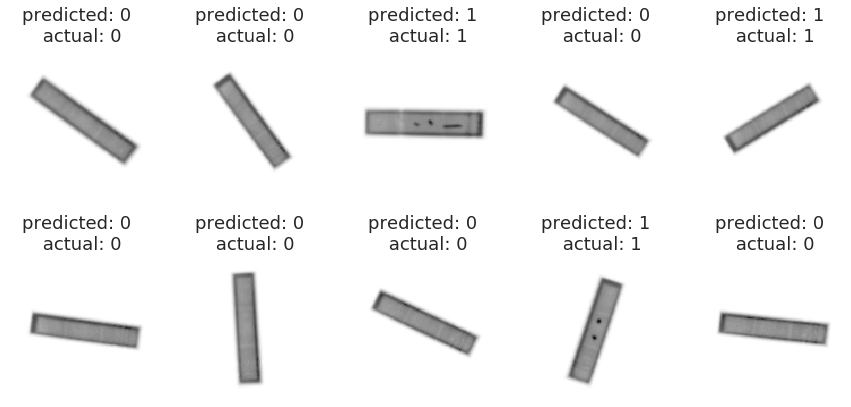

In [45]:
# show random 10 images that were correctly predicted
correct_idx = np.where(df_stacked['y_Predicted'] == df_stacked['y_Actual'])[0]

fig, axs = plt.subplots(2,5, figsize=(15, 7))
axs = axs.ravel()
for i in range(10):
    r = random.choice(correct_idx)
    axs[i].imshow(testAllX[r].reshape(img_width, img_height), cmap=cm.Greys_r, vmin=0, vmax=1)
    axs[i].set_title('predicted: {} \n actual: {}'.format(df_stacked['y_Predicted'][r], 
                                                          df_stacked['y_Actual'][r]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

#### Wrongly Predicted Images

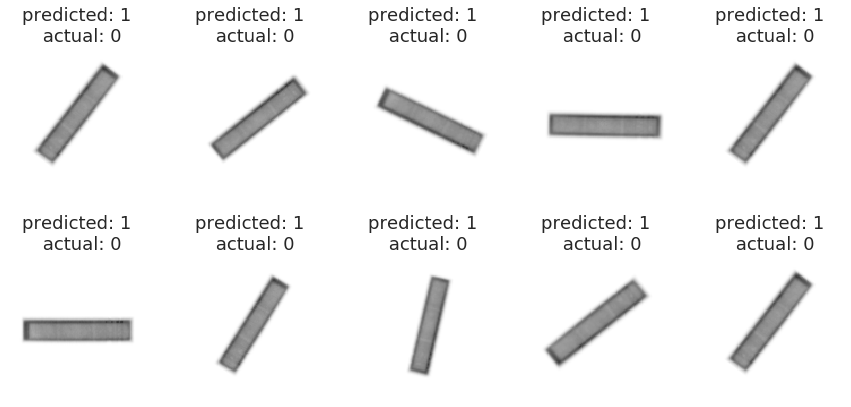

In [46]:
# show random 10 images that were wrongly predicted
wrong_idx = np.where(df_stacked['y_Predicted'] != df_stacked['y_Actual'])[0]

fig, axs = plt.subplots(2,5, figsize=(15, 7))
axs = axs.ravel()
for i in range(10):
    r = random.choice(wrong_idx)
    axs[i].imshow(testAllX[r].reshape(img_width, img_height), cmap=cm.Greys_r, vmin=0, vmax=1)
    axs[i].set_title('predicted: {} \n actual: {}'.format(df_stacked['y_Predicted'][r], 
                                                          df_stacked['y_Actual'][r]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

#### Most Anomalous Samples in the Test Set

Most anomalies from left to right

##### Only Anomaly Class

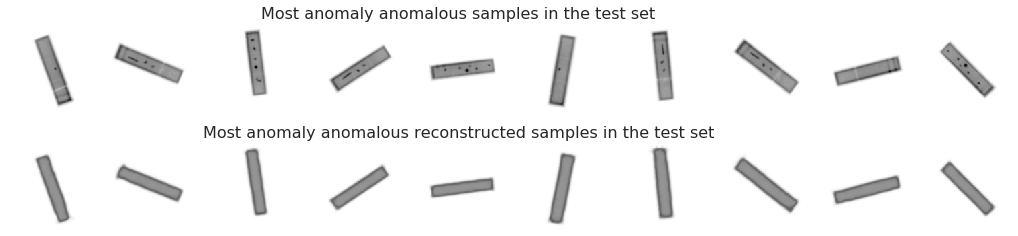

In [47]:
plot_top_anomalies(pd.Series(rec1), testAnomalyX, predAnomaly, n=10, img_width=img_width, img_height=img_height,
                       title1='Most anomaly anomalous samples in the test set', 
                       title2='Most anomaly anomalous reconstructed samples in the test set')

##### Only Normal Class

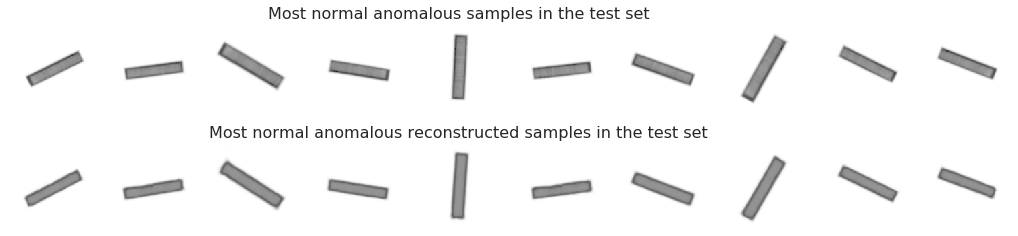

In [48]:
plot_top_anomalies(pd.Series(rec0), testNormalX, predNormal, n=10, img_width=img_width, img_height=img_height,
                       title1='Most normal anomalous samples in the test set', 
                       title2='Most normal anomalous reconstructed samples in the test set')

## Save specific measurements


In [49]:
# save all interesting evaluations metrics for statistical analysis
AllEvaluations = np.array((rec0_mean, rec1_mean, fpr, tpr, optimal_threshold, auc_score, 
                           specificity, sensitivity, precision, macro_precision, macro_recall, 
                           macro_f1, accuracy, misclassification))
AllEvaluations.shape

(14,)

In [50]:
filename  = f'J{latent_dim}_ZNCC.csv'
if append_measurements == True:
    with open(f'{MEASUREMENTS_FOLDER}/{filename}', 'a') as csvfile:
        headers = ['rec0_mean', 'rec1_mean', 'fpr', 'tpr', 'optimal_threshold', 'auc_score', 
                   'specificity', 'sensitivity', 'precision', 'macro_precision', 'macro_recall', 
                   'macro_f1', 'accuracy', 'misclassification']
        writer  = csv.DictWriter(csvfile, delimiter=',', fieldnames=headers)
        
        # file is empty, write a header
        csvfile.seek(0, 2)
        if csvfile.tell() == 0:
            writer.writeheader() 
            
        # append to new row (end of file):
        writer.writerow({f'{headers[0]}': AllEvaluations[0],     
                         f'{headers[1]}': AllEvaluations[1],
                         f'{headers[2]}': AllEvaluations[2],
                         f'{headers[3]}': AllEvaluations[3],
                         f'{headers[4]}': AllEvaluations[4],
                         f'{headers[5]}': AllEvaluations[5],
                         f'{headers[6]}': AllEvaluations[6],
                         f'{headers[7]}': AllEvaluations[7],
                         f'{headers[8]}': AllEvaluations[8],
                         f'{headers[9]}': AllEvaluations[9],
                         f'{headers[10]}': AllEvaluations[10],
                         f'{headers[11]}': AllEvaluations[11],
                         f'{headers[12]}': AllEvaluations[12],
                         f'{headers[13]}': AllEvaluations[13]
                        })       